Using device: cuda
Loading IMDB dataset...


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Training samples: 25000
Test samples: 25000
Sample data:
                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Sample tokenization:
Original text: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev
Tokens: ['i', 'rented', 'i', 'am', 'curious', '-', 'yellow', 'from', 'my', 'video']...
Tokenizing datasets...


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Using 5000 training samples and 1000 test samples
Loading BERT model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2985700759.py:133: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.324100,0.241484,0.911000
2,0.258300,0.298248,0.914000
3,0.069000,0.386333,0.919000


Evaluating model...


Evaluation results: {'eval_loss': 0.3863329589366913, 'eval_accuracy': 0.919, 'eval_runtime': 31.1001, 'eval_samples_per_second': 32.154, 'eval_steps_per_second': 2.026, 'epoch': 3.0}

Accuracy: 0.9190

Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.92      0.92       512
    Positive       0.92      0.92      0.92       488

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



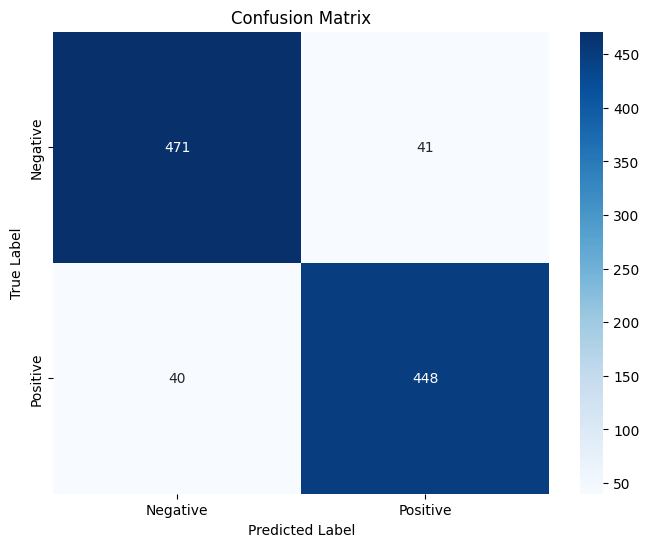

Saving model...

TESTING INFERENCE
Text: This movie was absolutely fantastic! Great acting and storyl...
Sentiment: Positive (Confidence: 0.999)
--------------------------------------------------
Text: Terrible movie, waste of time. Very boring and poorly acted....
Sentiment: Negative (Confidence: 0.999)
--------------------------------------------------
Text: The movie was okay, nothing special but watchable....
Sentiment: Negative (Confidence: 0.997)
--------------------------------------------------
Text: One of the best films I've ever seen! Highly recommended!...
Sentiment: Positive (Confidence: 0.999)
--------------------------------------------------
Text: Complete disaster. Couldn't even finish watching it....
Sentiment: Negative (Confidence: 0.997)
--------------------------------------------------

Training completed successfully!
Model saved in './fine-tuned-bert-imdb' directory


In [2]:
# BERT Fine-tuning for Text Classification on IMDB Dataset
# This code fine-tunes BERT for sentiment classification

# Install required packages
!pip install transformers datasets torch scikit-learn pandas numpy matplotlib

# Disable W&B logging
import os
os.environ["WANDB_DISABLED"] = "true"

import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. DATA PREPARATION
# Download IMDB dataset from Kaggle
# Alternative: You can manually download from https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
# For this example, we'll use the datasets library which has IMDB built-in

from datasets import load_dataset

# Load IMDB dataset
print("Loading IMDB dataset...")
dataset = load_dataset("imdb")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Convert to pandas for easier handling (optional)
train_df = train_dataset.to_pandas()
test_df = test_dataset.to_pandas()

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Sample data:")
print(train_df.head())

# 2. TOKENIZER SETUP
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Check tokenizer
sample_text = train_df['text'].iloc[0][:200]  # First 200 chars
tokens = tokenizer.tokenize(sample_text)
print(f"\nSample tokenization:")
print(f"Original text: {sample_text}")
print(f"Tokens: {tokens[:10]}...")  # Show first 10 tokens

# 3. DATA PREPROCESSING
def preprocess_data(examples):
    # Tokenize the texts
    return tokenizer(
        examples['text'],
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

# Apply preprocessing
print("Tokenizing datasets...")
train_dataset = train_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.map(preprocess_data, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Create smaller dataset for faster training (optional - remove for full dataset)
train_small = train_dataset.shuffle(seed=42).select(range(5000))  # Use 5000 samples
test_small = test_dataset.shuffle(seed=42).select(range(1000))   # Use 1000 samples

print(f"Using {len(train_small)} training samples and {len(test_small)} test samples")

# 4. MODEL SETUP
print("Loading BERT model...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification (positive/negative)
    id2label={0: "negative", 1: "positive"},
    label2id={"negative": 0, "positive": 1}
)

# Move model to GPU if available
model.to(device)

# 5. TRAINING SETUP
training_args = TrainingArguments(
    output_dir="./bert-imdb-classifier",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="epoch",  # Changed from evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    report_to=None,  # Disable wandb logging
)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
    }

# 6. TRAINER SETUP
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_small,
    eval_dataset=test_small,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 7. TRAINING
print("Starting training...")
trainer.train()

# 8. EVALUATION
print("Evaluating model...")
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# 9. DETAILED EVALUATION
def detailed_evaluation(trainer, test_dataset):
    # Get predictions
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy: {accuracy:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return y_pred, y_true

# Run detailed evaluation
y_pred, y_true = detailed_evaluation(trainer, test_small)

# 10. SAVE MODEL
print("Saving model...")
model.save_pretrained("./fine-tuned-bert-imdb")
tokenizer.save_pretrained("./fine-tuned-bert-imdb")

# 11. INFERENCE FUNCTION
def predict_sentiment(text, model, tokenizer):
    # Tokenize input text
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    )

    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0][predicted_class].item()

    sentiment = "Positive" if predicted_class == 1 else "Negative"
    return sentiment, confidence

# 12. TEST INFERENCE
print("\n" + "="*50)
print("TESTING INFERENCE")
print("="*50)

# Test examples
test_examples = [
    "This movie was absolutely fantastic! Great acting and storyline.",
    "Terrible movie, waste of time. Very boring and poorly acted.",
    "The movie was okay, nothing special but watchable.",
    "One of the best films I've ever seen! Highly recommended!",
    "Complete disaster. Couldn't even finish watching it."
]

for text in test_examples:
    sentiment, confidence = predict_sentiment(text, model, tokenizer)
    print(f"Text: {text[:60]}...")
    print(f"Sentiment: {sentiment} (Confidence: {confidence:.3f})")
    print("-" * 50)

print("\nTraining completed successfully!")
print("Model saved in './fine-tuned-bert-imdb' directory")